# Notebook Exploration

## Functions

In [288]:
import mlflow
import mlflow.sklearn
import numpy as np
import pandas as pd

def evaluate_and_log_metrics(experiment_name, lda_model, corpus_test_selected, text_data_test, dictionary_train_selected, model_type, training_time = None):

    log_perplexity = lda_model.log_perplexity(corpus_test_selected)
    perplexity = np.exp2(-log_perplexity)

    coherence_model = CoherenceModel(model=lda_model, texts=text_data_test, dictionary=dictionary_train_selected, coherence='c_v')
    
    coherence_score = coherence_model.get_coherence()

    with mlflow.start_run():
        mlflow.set_experiment(experiment_name)
        mlflow.log_param("model_type", model_type)
        mlflow.log_metric("Log-Perplexity", log_perplexity)
        mlflow.log_metric("Perplexity", perplexity)
        mlflow.log_metric("Coherence", coherence_score)
        if (training_time != None):
            mlflow.log_metric("training_time", training_time)

    return log_perplexity, perplexity, coherence_score

## Split dataset

In [289]:
from sklearn.model_selection import train_test_split

data = pd.read_csv("dataset_cleaned.csv")
train_data, test_data = train_test_split(data, test_size=0.2)

## LDA (Latent Dirichlet allocation)

### Préparer LDA sur les titres (pour un modèle simple)

In [290]:
from gensim.models import LdaModel
from gensim.corpora import Dictionary

# train
text_data_train_title = [[word.strip("[]'") for word in doc.split(', ')] for doc in train_data['title_lemmatized']]

text_data_train_title = [[word for phrase in doc for word in phrase.split()] for doc in text_data_train_title]

# test
text_data_test_title = [[word.strip("[]'") for word in doc.split(', ')] for doc in test_data['title_lemmatized']]

text_data_test_title = [[word for phrase in doc for word in phrase.split()] for doc in text_data_test_title]

dictionary_train_title = Dictionary(text_data_train_title)
corpus_train_title = [dictionary_train_title.doc2bow(word_list) for word_list in text_data_train_title]

corpus_test_title = [dictionary_train_title.doc2bow(word_list) for word_list in text_data_test_title]

# Entraînement du modèle LDA sur le train set
lda_model_title = LdaModel(corpus_train_title, num_topics=5, id2word=dictionary_train_title, passes=10)

# mots associés à chaque topic pour le titre
print("Mots associés à chaque topic pour le titre:")
for topic_idx, topic in lda_model_title.print_topics():
    print(f"Topic {topic_idx + 1}: {topic}")

log_perplexity_title = lda_model_title.log_perplexity(corpus_test_title)
perplexity_title = np.exp2(-log_perplexity_title)

print(f"Log-Perplexity: {log_perplexity_title}")
print(f"Perplexity: {perplexity_title}")

Mots associés à chaque topic pour le titre:
Topic 1: 0.015*"studio" + 0.014*"c" + 0.013*"difference" + 0.010*"use" + 0.010*"visual" + 0.010*"android" + 0.009*"python" + 0.009*"django" + 0.007*"key" + 0.007*"whats"
Topic 2: 0.015*"android" + 0.015*"ios" + 0.014*"using" + 0.014*"app" + 0.011*"image" + 0.010*"server" + 0.008*"get" + 0.008*"custom" + 0.007*"change" + 0.006*"working"
Topic 3: 0.017*"python" + 0.015*"using" + 0.013*"data" + 0.013*"file" + 0.012*"spring" + 0.011*"use" + 0.010*"aspnet" + 0.009*"way" + 0.008*"mvc" + 0.007*"core"
Topic 4: 0.021*"string" + 0.016*"value" + 0.013*"array" + 0.011*"function" + 0.010*"c" + 0.010*"vs" + 0.010*"convert" + 0.008*"using" + 0.008*"pandas" + 0.007*"list"
Topic 5: 0.017*"error" + 0.009*"two" + 0.008*"using" + 0.008*"install" + 0.008*"linux" + 0.008*"file" + 0.007*"framework" + 0.007*"windows" + 0.007*"files" + 0.007*"entity"
Log-Perplexity: -9.411445562959969
Perplexity: 680.9691179015801


In [291]:
# Afficher les mots correspondant à chaque index dans le premier document
for (index, freq) in corpus_train_title[0]:
    print(f"Mot: {dictionary_train_title[index]}, Fréquence: {freq}")

Mot: choice, Fréquence: 1
Mot: creating, Fréquence: 1
Mot: forms, Fréquence: 1
Mot: gui, Fréquence: 1
Mot: new, Fréquence: 1
Mot: preferred, Fréquence: 1
Mot: windows, Fréquence: 1
Mot: wpf, Fréquence: 1


### Trouver le nombre de topics avec la Perplexité (Avec title seulement)

In [292]:
from gensim.models import LdaModel
from gensim.corpora import Dictionary
import numpy as np
from gensim.models import CoherenceModel

# train
text_data_train_title = [[word.strip("[]'") for word in doc.split(', ')] for doc in train_data['title_lemmatized']]

text_data_train_title = [[word for phrase in doc for word in phrase.split()] for doc in text_data_train_title]

# test
text_data_test_title = [[word.strip("[]'") for word in doc.split(', ')] for doc in test_data['title_lemmatized']]

text_data_test_title = [[word for phrase in doc for word in phrase.split()] for doc in text_data_test_title]

dictionary_train_title = Dictionary(text_data_train_title)

dictionary_train_title.filter_extremes(no_below=5, no_above=0.6)

corpus_train_title = [dictionary_train_title.doc2bow(word_list) for word_list in text_data_train_title]
corpus_test_title = [dictionary_train_title.doc2bow(word_list) for word_list in text_data_test_title]

# nombres de topics à tester
num_topics_list = [5, 10, 20, 30, 50, 80, 100]

perplexity_scores = []
coherence_scores = []

for num_topics in num_topics_list:
    lda_model_title = LdaModel(corpus_train_title, num_topics=num_topics, id2word=dictionary_train_title, passes=10)

    log_perplexity_title = lda_model_title.log_perplexity(corpus_test_title)
    perplexity_title = np.exp2(-log_perplexity_title)
    perplexity_scores.append(perplexity_title)

    # score de cohérence
    coherence_model_title = CoherenceModel(model=lda_model_title, texts=text_data_train_title, dictionary=dictionary_train_title, coherence='c_v')
    coherence_score = coherence_model_title.get_coherence()
    coherence_scores.append(coherence_score)

    print("Nombre de Topics:", num_topics)
    print("  Score de Perplexité:", perplexity_title)
    print("  Score de Cohérence:", coherence_score)
    print()

best_num_topics = num_topics_list[np.argmin(perplexity_scores)]
best_num_topics_coh = num_topics_list[np.argmax(coherence_scores)]

print(f"Le nombre optimal de topics selon la perplexité est : {best_num_topics}")
print(f"Le nombre optimal de topics selon la cohérence des topics est : {best_num_topics_coh}")


Nombre de Topics: 5
  Score de Perplexité: 284.355783798308
  Score de Cohérence: 0.23296581957721352
Nombre de Topics: 10
  Score de Perplexité: 329.6103966488829
  Score de Cohérence: 0.273236843804804
Nombre de Topics: 20
  Score de Perplexité: 1560.9704576755685
  Score de Cohérence: 0.40829467048048806
Nombre de Topics: 30
  Score de Perplexité: 3633.6885898357527
  Score de Cohérence: 0.48957074630224107
Nombre de Topics: 50
  Score de Perplexité: 25549.255684837364
  Score de Cohérence: 0.573889471274967
Nombre de Topics: 80
  Score de Perplexité: 16274790.344201295
  Score de Cohérence: 0.5860708294581649
Nombre de Topics: 100
  Score de Perplexité: 370728148117.8052
  Score de Cohérence: 0.5710700698808663

Le nombre optimal de topics selon la perplexité est : 5
Le nombre optimal de topics selon la cohérence des topics est : 80


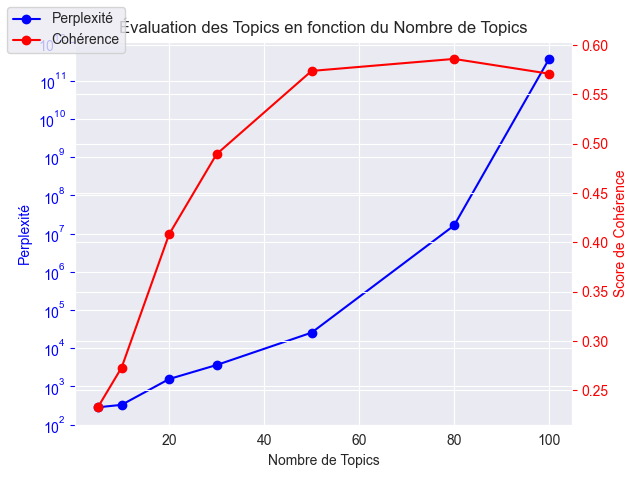

In [293]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()

ax1.plot(num_topics_list, perplexity_scores, marker='o', linestyle='-', color='b', label='Perplexité')
ax1.set_xlabel('Nombre de Topics')
ax1.set_ylabel('Perplexité', color='b')
ax1.tick_params('y', colors='b')

ax1.set_yscale('symlog')

ax2 = ax1.twinx()

ax2.plot(num_topics_list, coherence_scores, marker='o', linestyle='-', color='r', label='Cohérence')
ax2.set_ylabel('Score de Cohérence', color='r')
ax2.tick_params('y', colors='r')

plt.title('Évaluation des Topics en fonction du Nombre de Topics')
fig.tight_layout()
fig.legend(loc='upper left')

plt.show()


In [294]:
print(corpus_train_title)


[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1)], [(8, 1), (9, 1), (10, 1), (11, 1), (12, 1)], [(13, 1), (14, 1), (15, 1), (16, 1), (17, 1)], [(13, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1)], [(25, 1), (26, 1), (27, 1), (28, 1)], [(29, 1)], [(24, 1), (28, 1), (30, 1), (31, 1)], [(32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1)], [(38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1)], [(45, 1), (46, 1), (47, 1), (48, 1), (49, 1), (50, 1)], [(51, 1), (52, 1), (53, 1), (54, 1)], [(7, 1), (55, 1), (56, 1), (57, 1), (58, 1), (59, 1), (60, 1), (61, 1)], [(62, 1), (63, 1), (64, 1), (65, 1), (66, 1), (67, 1)], [(17, 1), (68, 1), (69, 1), (70, 1)], [(71, 1), (72, 1), (73, 1), (74, 1), (75, 1), (76, 1)], [(19, 1), (77, 1), (78, 1), (79, 1), (80, 1), (81, 1), (82, 1), (83, 1), (84, 1), (85, 1)], [(86, 1), (87, 1), (88, 1), (89, 1)], [(13, 1), (90, 1), (91, 1), (92, 1)], [(93, 1), (94, 1), (95, 1), (96, 1), (97, 1), (98, 1)], [(91, 1),

### Trouver le nombre de topics avec la Perplexité (Avec title et body)

In [295]:
from gensim.models import LdaModel
from gensim.corpora import Dictionary
import numpy as np

# train
text_data_train_title = [[word.strip("[]'") for word in doc.split(', ')] for doc in train_data['title_lemmatized']]
text_data_train_title = [[word for phrase in doc for word in phrase.split()] for doc in text_data_train_title]

text_data_train_body = [[word.strip("[]'") for word in doc.split(', ')] for doc in train_data['body_lemmatized']]
text_data_train_body = [[word for phrase in doc for word in phrase.split()] for doc in text_data_train_body]

text_data_train_combined = [title + body for title, body in zip(text_data_train_title, text_data_train_body)]

# test
text_data_test_title = [[word.strip("[]'") for word in doc.split(', ')] for doc in test_data['title_lemmatized']]
text_data_test_title = [[word for phrase in doc for word in phrase.split()] for doc in text_data_test_title]

text_data_test_body = [[word.strip("[]'") for word in doc.split(', ')] for doc in test_data['body_lemmatized']]
text_data_test_body = [[word for phrase in doc for word in phrase.split()] for doc in text_data_test_body]

text_data_test_combined = [title + body for title, body in zip(text_data_test_title, text_data_test_body)]


dictionary_train_combined = Dictionary(text_data_train_combined)

dictionary_train_combined.filter_extremes(no_below=5, no_above=0.6)

corpus_train_combined = [dictionary_train_combined.doc2bow(word_list) for word_list in text_data_train_combined]
corpus_test_combined = [dictionary_train_combined.doc2bow(word_list) for word_list in text_data_test_combined]

num_topics_list = [5, 10, 20, 30, 50, 80, 100]
perplexity_scores_combined = []
coherence_scores_combined = []

for num_topics in num_topics_list:    
    lda_model_combined = LdaModel(corpus_train_combined, num_topics=num_topics, id2word=dictionary_train_combined, passes=10)

    log_perplexity_combined = lda_model_combined.log_perplexity(corpus_test_combined)
    perplexity_combined = np.exp2(-log_perplexity_combined)
    
    perplexity_scores_combined.append(perplexity_combined)

    # score de cohérence
    coherence_model_combined = CoherenceModel(model=lda_model_combined, texts=text_data_train_combined, dictionary=dictionary_train_combined, coherence='c_v')
    coherence_score_combined = coherence_model_combined.get_coherence()
    coherence_scores_combined.append(coherence_score_combined)

    print("Nombre de Topics:", num_topics)
    print("  Score de Perplexité:", perplexity_combined)
    print("  Score de Cohérence:", coherence_score_combined)
    print()

best_num_topics_combined = num_topics_list[np.argmin(perplexity_scores_combined)]
best_num_topics_coh_combined = num_topics_list[np.argmax(coherence_scores_combined)]

print(f"Le nombre optimal de topics selon la perplexité est : {best_num_topics_combined}")
print(f"Le nombre optimal de topics selon la cohérence des topics est : {best_num_topics_coh_combined}")


Nombre de Topics: 5
  Score de Perplexité: 248.039781374597
  Score de Cohérence: 0.5038849132737875
Nombre de Topics: 10
  Score de Perplexité: 285.532878971216
  Score de Cohérence: 0.5366056350624733
Nombre de Topics: 20
  Score de Perplexité: 462.1391828102081
  Score de Cohérence: 0.551019811008081
Nombre de Topics: 30
  Score de Perplexité: 634.0490195782852
  Score de Cohérence: 0.5521582311361021
Nombre de Topics: 50
  Score de Perplexité: 1243.1784934355285
  Score de Cohérence: 0.5158723297170613
Nombre de Topics: 80
  Score de Perplexité: 3375.026550166515
  Score de Cohérence: 0.48706364019767817
Nombre de Topics: 100
  Score de Perplexité: 6644.477256900507
  Score de Cohérence: 0.46489445865059814

Le nombre optimal de topics selon la perplexité est : 5
Le nombre optimal de topics selon la cohérence des topics est : 30


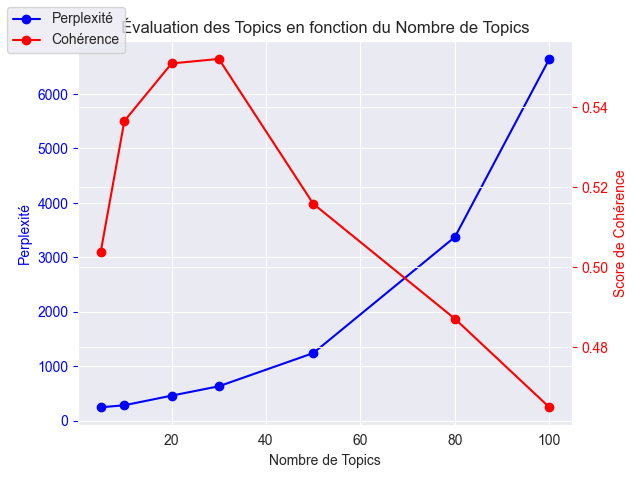

In [296]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()

ax1.plot(num_topics_list, perplexity_scores_combined, marker='o', linestyle='-', color='b', label='Perplexité')
ax1.set_xlabel('Nombre de Topics')
ax1.set_ylabel('Perplexité', color='b')
ax1.tick_params('y', colors='b')

ax2 = ax1.twinx()

ax2.plot(num_topics_list, coherence_scores_combined, marker='o', linestyle='-', color='r', label='Cohérence')
ax2.set_ylabel('Score de Cohérence', color='r')
ax2.tick_params('y', colors='r')

plt.title('Évaluation des Topics en fonction du Nombre de Topics')
fig.tight_layout()
fig.legend(loc='upper left')

plt.show()


## Sélection du meilleur modèle LDA

In [297]:
from gensim.models import LdaModel
import time

# nombre de mots clés à afficher pour chaque topic
num_words = 30

# nombre de topics
num_topics = 20

start_time = time.time()

# créer un modèle LDA et l'entraîner sur les données
lda_selected = LdaModel(corpus=corpus_train_combined, num_topics=num_topics, id2word=dictionary_train_combined, passes=10,random_state=42)

end_time = time.time()
training_time = end_time - start_time
print("Temps d'entrainement:", training_time, "secondes")

# mots clés pour chaque topic
for topic_idx in range(num_topics):
    print(f"Topic {topic_idx + 1}:")
    print(lda_selected.show_topic(topic_idx, topn=num_words))
    print()


Temps d'entrainement: 58.062748193740845 secondes
Topic 1:
[('project', 0.029512757), ('build', 0.020950172), ('file', 0.018335776), ('studio', 0.01671067), ('version', 0.013003638), ('error', 0.012788575), ('visual', 0.012744783), ('files', 0.0118455915), ('compile', 0.010379025), ('npm', 0.010285613), ('git', 0.009916697), ('dependencies', 0.009346655), ('android', 0.008719219), ('debug', 0.008072616), ('library', 0.0079231635), ('dependency', 0.0077721006), ('using', 0.00743412), ('plugin', 0.007384163), ('eclipse', 0.0069335457), ('warning', 0.0068076104), ('found', 0.0067205746), ('find', 0.006677235), ('package', 0.006512677), ('source', 0.0064530578), ('run', 0.0064079403), ('jar', 0.0058122715), ('get', 0.005791574), ('err', 0.0056167953), ('maven', 0.0054492904), ('gradle', 0.0052889474)]

Topic 2:
[('im', 0.018381514), ('like', 0.018270068), ('would', 0.015025131), ('way', 0.01151385), ('ive', 0.01113998), ('use', 0.009909112), ('using', 0.008574565), ('one', 0.00847882), ('k

### Mapping manuel des noms des topics après analyse des corpus

In [298]:
topic_names = {
    0: "mobile-development",
    1: "web",
    2: "java",
    3: "software-design",
    4: "python",
    5: "server-side",
    6: "frameworks",
    7: "code-structure",
    8: "javascript",
    9: "paradigms",
    10: "file-handling",
    11: "ios",
    12: "spring",
    13: "devtools",
    14: "user-interface",
    15: "methodology",
    16: "configuration",
    17: "data-modeling",
    18: "asp.net",
    19: "optimization"
}


### Visualisation des topics avec pyLDAvis

In [299]:
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

# prépare les données pour la visualisation
lda_vis_data = gensimvis.prepare(lda_selected, corpus_train_combined, dictionary_train_combined)

# graphique interactif
pyLDAvis.display(lda_vis_data)


### Prédiction des 5 meilleures catégories / tags

In [300]:
from gensim.utils import simple_preprocess

# prétraiter le texte
def simple_preprocess_text(text):
    return simple_preprocess(text)

# distributions de probabilité des topics pour une phrase donnée
def get_topic_distribution(model, dictionary, text):
    text_tokens = simple_preprocess_text(text)
    text_bow = dictionary.doc2bow(text_tokens)
    return model.get_document_topics(text_bow)

phrase = "Accuracy issue in classification model"

# distributions de probabilité des topics pour la phrase
topic_distribution = get_topic_distribution(lda_selected, dictionary_train_combined, phrase)

# trier les topics par probabilité
sorted_topics = sorted(topic_distribution, key=lambda x: x[1], reverse=True)

# sélectionner les cinq premiers topics
top_5_topics = sorted_topics[:5]

for topic in top_5_topics:
    topic_idx, prob = topic
    topic_name = topic_names.get(topic_idx, f"Topic {topic_idx}")
    print(f"{topic_name}: Probability: {prob}")
    print(lda_selected.show_topic(topic_idx, topn=num_words))
    print()

frameworks: Probability: 0.6175268888473511
[('data', 0.039512027), ('memory', 0.02840534), ('size', 0.020827955), ('shr', 0.0133548435), ('model', 0.01051544), ('stream', 0.009717759), ('using', 0.009589155), ('video', 0.009389783), ('bytes', 0.009076295), ('byte', 0.008416517), ('plot', 0.008349706), ('trees', 0.0073405686), ('buffer', 0.007261762), ('read', 0.0070256903), ('graph', 0.006883536), ('binary', 0.0066991835), ('output', 0.006485717), ('heap', 0.006219899), ('node', 0.0060345945), ('characters', 0.0059820954), ('utf8', 0.005817663), ('encoding', 0.005774797), ('array', 0.005667376), ('file', 0.0053068837), ('cache', 0.0051762154), ('input', 0.0051011224), ('points', 0.0050576157), ('limit', 0.005056236), ('large', 0.004804522), ('number', 0.004786333)]

devtools: Probability: 0.2024538367986679
[('error', 0.1299677), ('message', 0.027200144), ('exception', 0.024380002), ('try', 0.01594465), ('log', 0.014894602), ('code', 0.014663966), ('stack', 0.014396323), ('errors', 0.

### Évaluation (perplexité et cohérence score)

In [301]:
experiment_name = 'CountVectorizer - LDA model'

log_perplexity, perplexity, coherence_score = evaluate_and_log_metrics(experiment_name, lda_selected, corpus_test_combined, text_data_test_combined, dictionary_train_combined, 'combined', training_time = None)

print("Nombre de Topics:", num_topics)
print("  Score de Perplexité:", perplexity)
print("  Score de Log Perplexité:", log_perplexity)
print("  Score de Cohérence:", coherence_score)
print()

Nombre de Topics: 20
  Score de Perplexité: 455.769720945064
  Score de Log Perplexité: -8.832161272136993
  Score de Cohérence: 0.5215652020736886


## TF-IDF - LDA

In [302]:
from gensim.models import TfidfModel
from gensim.corpora import Dictionary
import numpy as np

dictionary = Dictionary(text_data_train_combined)
dictionary.filter_extremes(no_below=5, no_above=0.6)
corpus = [dictionary.doc2bow(text) for text in text_data_train_combined]
tfidf_model = TfidfModel(corpus)
corpus_tfidf = tfidf_model[corpus]

start_time = time.time()

lda_model = LdaModel(corpus_tfidf, num_topics=10, id2word=dictionary, passes=10)

end_time = time.time()
training_time_tdidf = end_time - start_time
print("Temps d'entrainement:", training_time_tdidf, "secondes")

corpus_test_tfidf = tfidf_model[[dictionary.doc2bow(text) for text in text_data_test_combined]]

Temps d'entrainement: 47.39018392562866 secondes


In [303]:
experiment_name = 'TF-IDF - LDA model'

log_perplexity, perplexity, coherence_score = evaluate_and_log_metrics(experiment_name, lda_model, corpus_test_tfidf, text_data_test_combined, dictionary, 'combined', training_time = training_time_tdidf)

print("Nombre de Topics:", num_topics)
print("  Score de Perplexité:", perplexity)
print("  Score de Log Perplexité:", log_perplexity)
print("  Score de Cohérence:", coherence_score)
print()

Nombre de Topics: 20
  Score de Perplexité: 3014.9348244644757
  Score de Log Perplexité: -11.557911099577426
  Score de Cohérence: 0.5941418618338512
